## MS COCO 데이터를 한글캡셔닝으로 학습시킨 모델
### 텐서플로우 케라스 토크나이저를 사용하였으며, 세부내용은 아래와 같습니다.

학습 데이터 수 : 123287장(사진), 616767문장(캡션수)<br>
top_k = 73000 / vocab_size = 73001 / max_length = 52<br>
Batch_size = 64, Buffer_size = 1000, embedding_dim = 256<br>
units = 512 / features_shape = 2048 / attention_features_shape = 64<br>

Epoch 1 Loss 0.910762<br>
Epoch 2 Loss 0.774115<br>
Epoch 3 Loss 0.722089<br>
Epoch 4 Loss 0.679618<br>


In [19]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Download image files / 모델 테스트용 사진으로 사용하기 위해 다운로드 하는 것이므로 반드시 안하셔도 됩니다.
# 해당 학습모델을 학습시킬때 사용한 데이터 셋이므로 정확도는 높게 나옵니다.
image_folder = '/val014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)

6645022720/6645013297 [==============================] - 398s 0us/step


In [22]:
# Feel free to change these parameters according to your system's configuration
# 해당 모델에 들어가야하는 필수 변수들이며, 학습시킬때의 수치와 일치화 시켜주었습니다.
top_k = 73000 # 토큰화 코드 확인 : 영어 : 42000 / 한국어 : 73000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
max_length = 38
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

In [24]:
import pandas as pd
path = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/이미지캡셔닝/Image Captioning(한글모델)/Tensorflow_Keras_T(Check_point)/tokenizer(index_word).csv'
word_index = pd.read_csv(path)
tokenizer.index_word = dict(zip(word_index['key'], word_index['value']))
tokenizer.word_index = dict(zip(word_index['value'], word_index['key']))
tokenizer.index_word[0], tokenizer.word_index['<pad>'] 

('<pad>', 0)

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## 모델

재미있는 사실: 아래의 디코더는 [Attention을 사용한 신경망 기계 번역](https://www.tensorflow.org/text/tutorials/nmt_with_attention)의 디코더와 동일합니다.

모델 아키텍처는 [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) 논문에서 영감을 얻었습니다.

- 이 예제에서는 InceptionV3의 하위 컨볼루셔널 레이어에서 특성을 추출하여 형상 (8, 8, 2048)의 백터를 제공합니다.
- (64, 2048)의 형상으로 스쿼시합니다.
- 그런 다음, 이 벡터는 CNN Encoder(단일 완전 연결 레이어로 구성)를 통해 전달됩니다.
- RNN(여기서는 GRU)이 다음 단어를 예측하기 위해 이미지를 살펴봅니다.

In [27]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [28]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [29]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [30]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [95]:
# encoder.summary()
decoder.summary()

Model: "rnn__decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  18688256  
                                                                 
 gru_1 (GRU)                 multiple                  1575936   
                                                                 
 dense_7 (Dense)             multiple                  262656    
                                                                 
 dense_8 (Dense)             multiple                  37449513  
                                                                 
 bahdanau_attention_1 (Bahda  multiple                 394753    
 nauAttention)                                                   
                                                                 
Total params: 58,371,114
Trainable params: 58,371,114
Non-trainable params: 0
________________________________________

In [31]:
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
checkpoint = 'ckpt-4'
checkpoint_use = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/이미지캡셔닝/Image Captioning(한글모델)/Tensorflow_Keras_T(Check_point)/' + checkpoint
ckpt.restore(checkpoint_use)

## 캡션!

- evaluate 함수는 여기에서 teacher forcing을 사용하지 않는다는 점을 제외하고 훈련 루프와 유사합니다. 각 타임스텝에서 decoder로의 입력은 hidden state 및 encoder 출력과 함께 이전 예측값입니다.
- 모델이 end 토큰을 예측할 때 예측을 중지합니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [32]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [33]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [34]:
import os
path_dir = '/content/val2014/'
file_dir = os.listdir(path_dir)
path_dir + file_dir[0]

'/content/val2014/COCO_val2014_000000031322.jpg'

/content/val2014/COCO_val2014_000000445128.jpg
예측문장1: 노트북에 있는 여자 옷을 입고 보는 동안 사람들이 플라스틱으로 된 우산을 들고 있다 <end>
예측문장2: 사과 커피 테이블에서 야외에 앉아 있는 남자 <end>
예측문장3: 한 남자가 밤에 빨간 우산을 들고 있는 모습 <end>
예측문장4: 우산과 두 사람이 우산을 들고 음료를 마시고 있다 <end>
예측문장5: 한 남자가 빨간 우산을 들고 있다 <end>


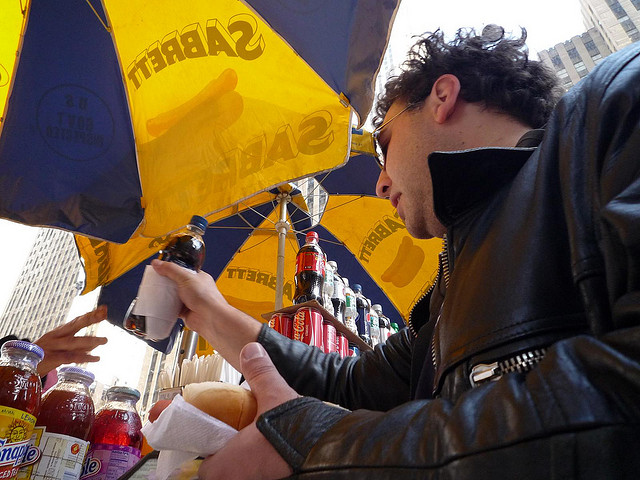

In [83]:
import random 
i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
# image_path = '/content/1.jpg'
image_path = path_dir + file_dir[i]
print(image_path)

prediction_list = []
for i in range(5):
  result, attention_plot = evaluate(image_path)
  print(f'예측문장{i+1}:', ' '.join(result))
  prediction_list.append(' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [84]:
for i in range(len(prediction_list)):
  prediction_list[i] = prediction_list[i].replace(' <end>', '')

## (KoGPT2-브런치(일기_10289개)

In [ ]:
!pip install transformers
!pip install datasets

In [72]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
from tqdm.notebook import tqdm

def load_model(model_path):
  model = GPT2LMHeadModel.from_pretrained(model_path)
  return model

def load_tokenizer(tokenizer_path):
  tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
  return tokenizer

def generate_text(sequence, max_lenth):
  model_path = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/gpt/브런치(일기)_모델(KoGPT)/checkpoint-316000'
  model = load_model(model_path)
  tokenizer = load_tokenizer(model_path)
  ids = tokenizer.encode(f'{sequence},', return_tensors = 'pt')
  final_outputs = model.generate(
      ids,
      do_sample = True,
      max_length = max_length,
      pad_token_id = model.config.pad_token_id,
      tok_k = 5, # 가장 높은 확률을 지닌 n개의 단어수 중에서 추출
      top_p = 0.90, # 누적확률이 n%인 단어까지 포함하여 그 중에서 추출
      repetition_penalty = 1.5, # 단어사용 반복에 대한 패널티 부여
  )
  return tokenizer.decode(final_outputs[0])

In [85]:
sequence = prediction_list[0]
max_length = 128
sentence_list = []
# sentence_list.append(generate_text(sequence, max_length))
sentence = generate_text(sequence, max_length)

In [86]:
ch_sentence = sentence.split(sequence + ', ')[1]
print(f'입력값 : {sequence}')
ch_sentence = ch_sentence.replace('.', '. ')
ch_sentence = ch_sentence.replace('\n', ' ')
ch_sentence = ch_sentence.replace('\"', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('  ', ' ')
ch_sentence = ch_sentence.replace('. ', '.\n')
print(ch_sentence)

입력값 : 노트북에 있는 여자 옷을 입고 보는 동안 사람들이 플라스틱으로 된 우산을 들고 있다
나는 아무 생각이 없었다.
아니, 왜 그럴까.
이 고양이는 뭘 때문인지가 조금 궁금할 뿐이었다.
택배를 보내러 온 길에는 아직 아무런 말도 할 수가 없다.
아빠에게 물었다.
오늘 고양이 근처에서 만났는데 여기밖에 못 데려왔어요.
뭐 하려고 밖에 나가서 그런 건데.
응 어디로 갔지 갑자기 말이 없어진다.
망아지처럼 고개를 돌려 걸음을 늦춰야 했고, 그 뒤로는 잘 들리지 않는다.
같이 사는 베트남계 미국인 친구도 사실은 엄청 친절하고 똑똑한 아이였다는 말을 믿을 수 없어 했다.
그들은
